In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import h5py

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.file = h5py.File('mydataset.hdf5','r')
        self.len = len(self.file['delta_map'])
    
    def __del__(self):
        self.file.close()

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        outputs = torch.Tensor(self.file['delta_map'][idx,:,:]).permute([2,0,1])
        inputs = torch.Tensor(self.file['train'][idx,:,:]).unsqueeze(0)
        return inputs, outputs

In [3]:
class DiffusionRegressor(nn.Module):
  def __init__(self):
    super(DiffusionRegressor, self).__init__()
    self.ker = nn.Parameter(torch.Tensor(torch.rand((1,1,7,7))))
    self.bias = nn.Parameter(torch.Tensor([0]))

  def matrixProduct(self,x):
    return F.conv2d(x,self.ker,padding='same')

  def matrixProductTranspose(self,x):
    return F.conv2d(x,torch.flip(self.ker,[2,3]),padding='same')

  def innerProduct(self,u,v):
    return torch.sum(u * v, dim = [1,2,3]).reshape([-1,1,1,1])
  
  def forward(self,img):
    img = img.detach()
    x = torch.rand_like(img)
    # Residual Norm Steepest Descent Algorithm
    r = img - self.matrixProduct(x)
    for j in range(10):
      v = self.matrixProductTranspose(r)
      Av = self.matrixProduct(v)
      alpha = self.innerProduct(v,v)/self.innerProduct(Av,Av)
      x = x + alpha*v
      r = r - alpha*Av
    x = x+self.bias
    return x

In [4]:
train_dataset = CustomDataset()

In [5]:
model = DiffusionRegressor().cuda()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
print(model.ker)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 16)
for t in range(10):
  cumulative_loss = 0
  for _, (train, deltamap) in enumerate(train_dataloader):
    train, deltamap = train.cuda(), deltamap[:,0,:,:].cuda().unsqueeze(1)
    output = model(train)
    loss = loss_fn(deltamap, output)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    cumulative_loss += loss.item()
  print(t, cumulative_loss)

Parameter containing:
tensor([[[[0.3137, 0.2179, 0.1255, 0.8744, 0.1085, 0.1489, 0.5344],
          [0.8871, 0.6593, 0.7032, 0.5888, 0.7452, 0.8981, 0.6929],
          [0.1712, 0.2777, 0.7857, 0.0916, 0.4943, 0.3186, 0.3253],
          [0.1800, 0.6295, 0.8982, 0.6092, 0.1123, 0.8634, 0.4955],
          [0.9660, 0.2116, 0.4632, 0.7112, 0.1344, 0.2926, 0.4688],
          [0.8720, 0.8249, 0.3552, 0.1852, 0.7969, 0.1145, 0.3747],
          [0.9482, 0.5937, 0.1022, 0.6703, 0.2427, 0.3710, 0.8532]]]],
       device='cuda:0', requires_grad=True)
0 739.2314162254333
1 738.6801331043243


KeyboardInterrupt: 

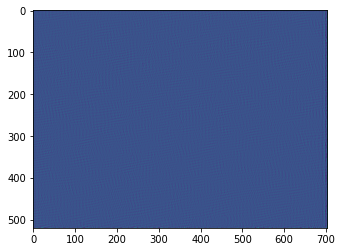

tensor(0.0792) tensor(0.1848)


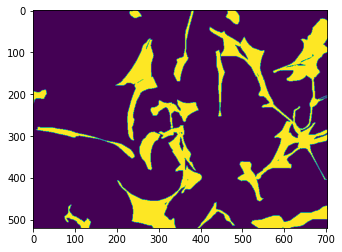

tensor(0.) tensor(1.)


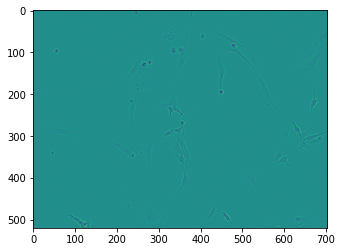

tensor(0.0118) tensor(1.)


In [ ]:
import matplotlib.pyplot as plt
for _ in [output,deltamap, train]:
    x = _.detach().cpu()[0,0,:,:]
    plt.imshow(x)
    plt.colorbar()
    plt.show()
    print(x.min(),x.max())

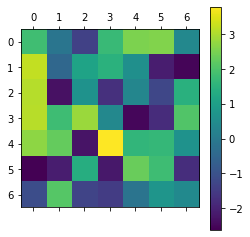

Parameter containing:
tensor([-2.1605], device='cuda:0', requires_grad=True)


In [ ]:
plt.matshow(model.ker.detach().cpu().squeeze())
plt.colorbar()
plt.show()
print(model.bias)